# 4 - Face Recognition
### Imports

In [21]:
# basic
import os
import cv2
import cvlib as cv
import numpy as np
import matplotlib.pyplot as plt

# SkLearn
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix, accuracy_score
from skimage.feature import hog, local_binary_pattern

# constants
num_components=100     # TODO choose the appropriate number for K

### File Load

Training Images


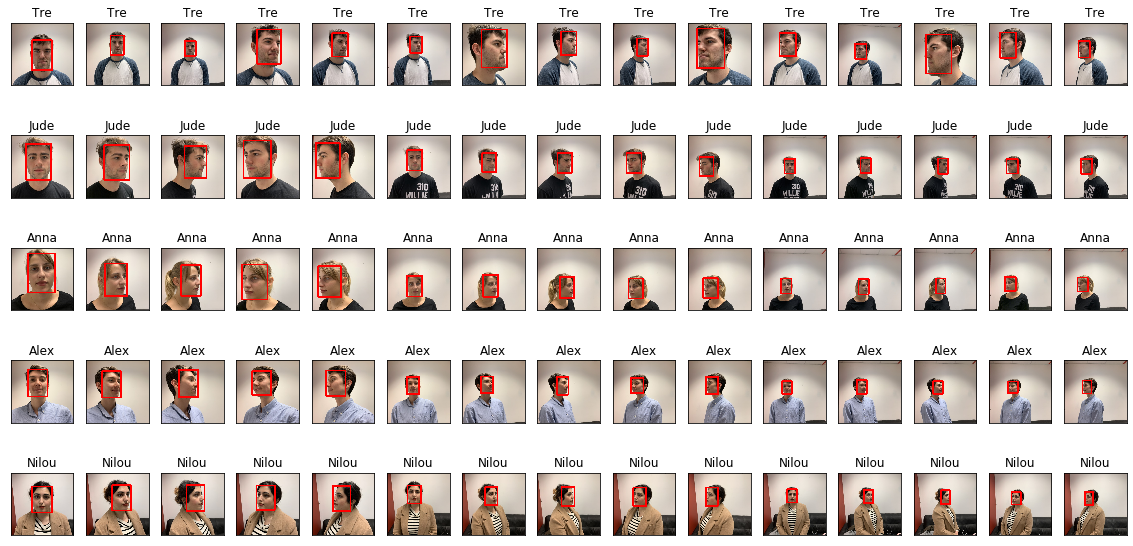

Test Images


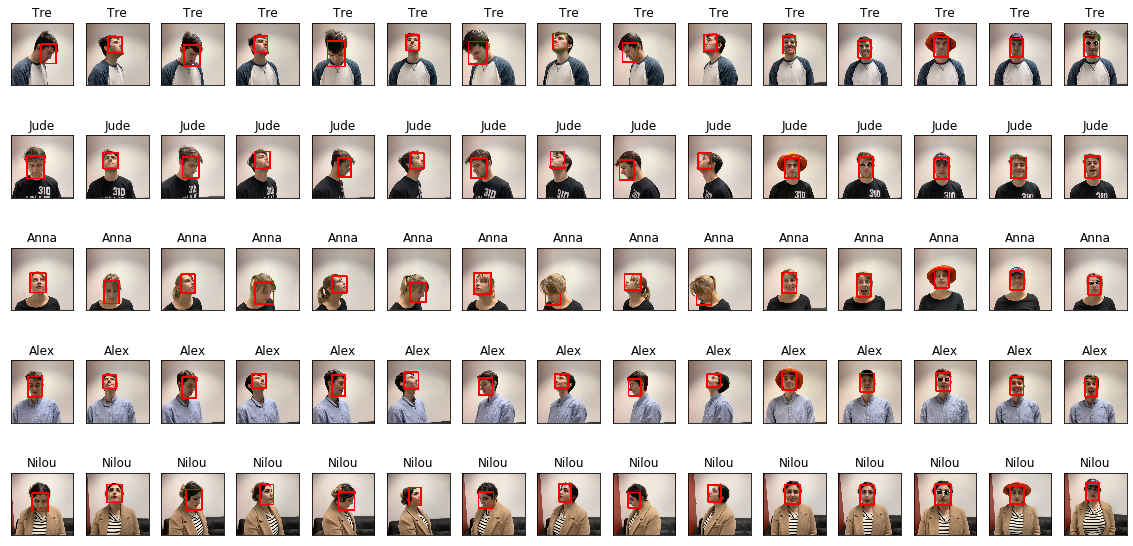

In [2]:
trainDir = "photos/preprocessed/train/"
trainHeadshots = np.empty((75, 256, 256, 3), dtype=np.uint8)
# trainBoundingBoxes = np.uint8(np.loadtxt(trainDir + "faceBoxes.txt"))
trainBoundingBoxes = np.empty((75, 4), dtype=np.uint8)
labels = np.repeat(np.array([0, 1, 2, 3, 4]), 15)
names = ["Tre", "Jude", "Anna", "Alex", "Nilou"]

print("Training Images")
plt.figure(figsize=(20, 10))
for index, filename in enumerate(os.listdir(trainDir)):
    # load images and convert to RGB
    trainHeadshots[index] = np.uint8(cv2.cvtColor(cv2.imread(os.path.join(trainDir, filename)), cv2.COLOR_BGR2RGB))

    # find bounding box of face
    face, confidence = cv.detect_face(trainHeadshots[index])
    trainBoundingBoxes[index] = [face[0][0], face[0][1], face[0][2], face[0][3]]

    # copy bounding box onto image for visual verification
    headshot_display = trainHeadshots[index].copy()
    cv2.rectangle(headshot_display, (trainBoundingBoxes[index][0], trainBoundingBoxes[index][1]), (trainBoundingBoxes[index][2], trainBoundingBoxes[index][3]), (255), thickness=5)
    plt.subplot(5, 15, index + 1)
    plt.title(names[labels[index]])
    plt.xticks([]), plt.yticks([])
    plt.imshow(headshot_display)
plt.show()


testDir = "photos/preprocessed/test/"
testHeadshots = np.empty((75, 256, 256, 3), dtype=np.uint8)
# testBoundingBoxes = np.uint8(np.loadtxt(testDir + "faceBoxes.txt"))
testBoundingBoxes = np.empty((75, 4), dtype=np.uint8)

print("Test Images")
plt.figure(figsize=(20, 10))
for index in range(75):
    # load images and convert to RGB
    testHeadshots[index] = np.uint8(cv2.cvtColor(cv2.imread(os.path.join(testDir, 'img' + str(index) + '.jpg')), cv2.COLOR_BGR2RGB))
    
    # find bounding box of face
    face, confidence = cv.detect_face(testHeadshots[index])
    if len(face) > 0:
        testBoundingBoxes[index] = [face[0][0], face[0][1], face[0][2], face[0][3]]
    else:
        # manual entry for the test image where Anna's hair obscures her face
        testBoundingBoxes[index] = [34, 189, 95, 235]

    # copy bounding box onto image for visual inspection
    headshot_display = testHeadshots[index].copy()
    cv2.rectangle(headshot_display, (testBoundingBoxes[index][0], testBoundingBoxes[index][1]), (testBoundingBoxes[index][2], testBoundingBoxes[index][3]), (255), thickness=5)

    plt.subplot(5, 15, index + 1)
    plt.title(names[labels[index]])
    plt.xticks([]), plt.yticks([])
    plt.imshow(headshot_display)
plt.show()

## 4.1 - Training: Building Vocabulary

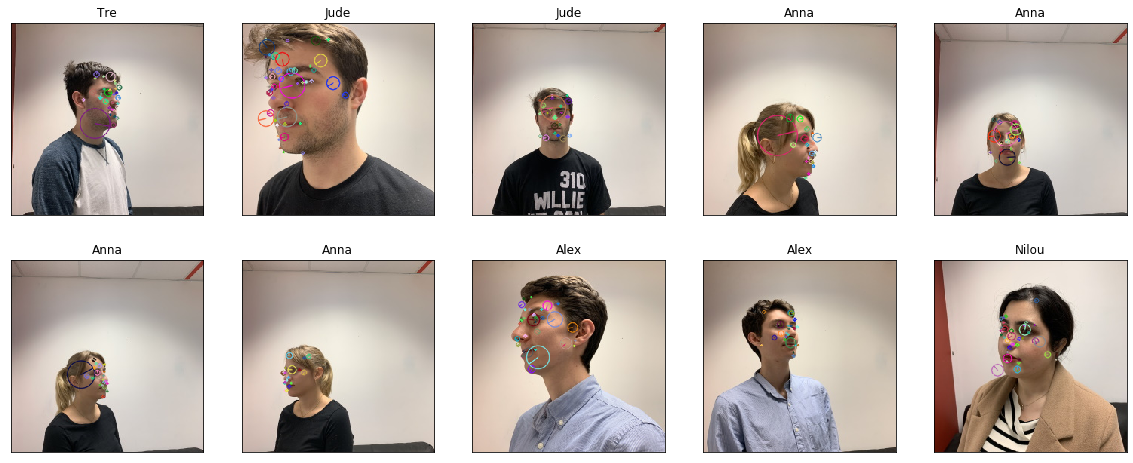

In [3]:
# create SIFT object
sift = cv2.xfeatures2d.SIFT_create()

# holder variables for keypoints, descriptors
trainKeypoints =  []
trainDescriptors = []

# randomly select 10 images to display
dispImages = np.random.randint(0, labels.shape[0], 10)

displayedImages = 1
plt.figure(figsize=(20, 8))
for index, (headshot, boundingBox, label) in enumerate(zip(trainHeadshots, trainBoundingBoxes, labels)):
    mask = np.zeros(headshot.shape[:2], dtype=np.uint8)
    cv2.rectangle(mask, (boundingBox[0], boundingBox[1]), (boundingBox[2], boundingBox[3]), (255), thickness=-1)
    keypoints, descriptors = sift.detectAndCompute(headshot, mask)
    
    # save
    trainKeypoints.append(keypoints)
    trainDescriptors.append(descriptors)

    if index in dispImages:
        headshot_display = headshot.copy()
        cv2.drawKeypoints(headshot, keypoints, headshot_display, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.subplot(2, 5, displayedImages), plt.imshow(headshot_display), plt.title(names[label])
        plt.xticks([]), plt.yticks([])
        displayedImages += 1
plt.show()

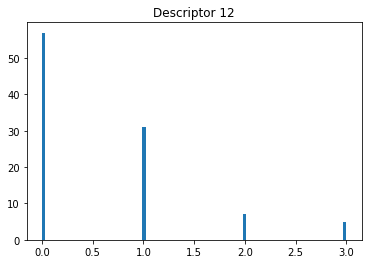

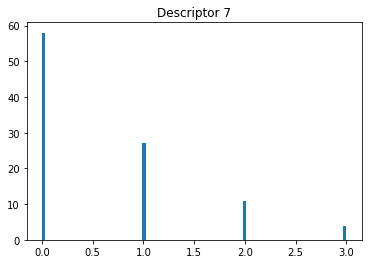

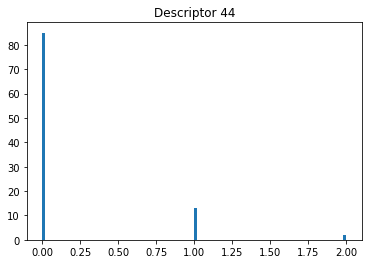

In [6]:
def buildHistograms(trnDesc, emModel):
    trnHist = []
    for descriptor in trnDesc:
        histogram = np.zeros(len(em.means_))
        for i in emModel.predict(descriptor):
            histogram[i] += 1.0
        trnHist.append(histogram)
    return trnHist

# cluster descriptors into K clusters using the Gaussian Mixture model
em = GaussianMixture(n_components=num_components)
em = em.fit(np.concatenate(trainDescriptors))

trainHistograms = buildHistograms(trainDescriptors, em)

for i in np.random.randint(0, len(trainHistograms), 3):
    plt.hist(trainHistograms[i], bins=num_components)
    plt.title("Descriptor {}".format(i))
    plt.show()

## 4.2 - Testing: Face Recognition

In [7]:
# create SIFT object
sift = cv2.xfeatures2d.SIFT_create()

# holder variables for keypoints, descriptors, and labels
testKeypoints =  []
testDescriptors = []

for index, (headshot, boundingBox) in enumerate(zip(testHeadshots, testBoundingBoxes)):
    mask = np.zeros(headshot.shape[:2], dtype=np.uint8)
    cv2.rectangle(mask, (boundingBox[0], boundingBox[1]), (boundingBox[2], boundingBox[3]), (255), thickness=-1)
    keypoints, descriptors = sift.detectAndCompute(headshot, mask)
    
    # save
    testKeypoints.append(keypoints)
    testDescriptors.append(descriptors)

#     # display images (debugging purposes)
#     headshot_display = headshot.copy()
#     cv2.drawKeypoints(headshot, keypoints, headshot_display, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#     plt.subplot(6, 15, index + 1)
#     plt.xticks([]), plt.yticks([]), plt.title(index), plt.imshow(headshot_display)
# plt.show()

testHistograms = buildHistograms(testDescriptors, em)

In [8]:
# trnHistList = the list of histograms of your training set (used to fit the nearest neighbour classifier)
# tstHistList = the list of histograms of your test set (the histograms you'd like to classify)
# numNeighbours = number of nearest neighbours you'd like to consider when determining the label
def findNearestNeighbour(trnHistList, tstHistList, numNeighbours=1):
    # nearestHistograms = []        # (distances, indices)
    predictedLabels = []

    nn = NearestNeighbors(n_neighbors=numNeighbours)
    nn.fit(trnHistList)

    for histogram in tstHistList:
        dist, result = nn.kneighbors([histogram])
        # nearestHistograms.append((dist[0], result[0]))
        predictedLabels.append(labels[result[0][0]])
    
    return predictedLabels

## 4.2.1 - Evaluation

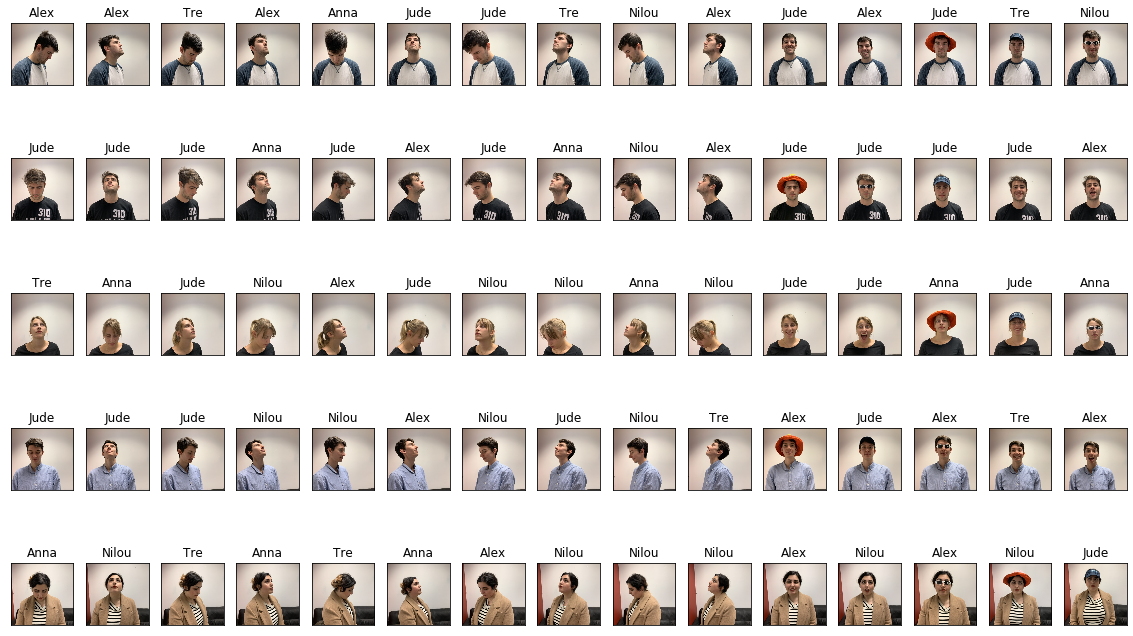

Recognition Rate: 0.3466666666666667


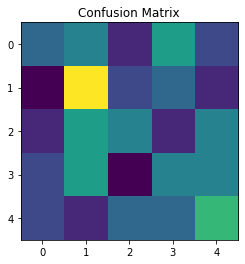

(<matplotlib.image.AxesImage at 0x23767395fc8>,
 Text(0.5, 1, 'Confusion Matrix'),
 None)

In [9]:
nearestHistogramLabels = findNearestNeighbour(trainHistograms, testHistograms)

plt.figure(figsize=(20,12))
for index, (headshot, histLabel) in enumerate(zip(testHeadshots, nearestHistogramLabels)):
    plt.subplot(5, 15, index + 1)
    plt.title(names[histLabel])
    plt.xticks([]), plt.yticks([])
    plt.imshow(headshot)
plt.show()

print('Recognition Rate: {}'.format(accuracy_score(labels, nearestHistogramLabels)))
plt.imshow(confusion_matrix(labels, nearestHistogramLabels)), plt.title('Confusion Matrix')
plt.show()

## Data Export

In [10]:
# dimensions: 75 pictures x number of keypoints x 2 points (x, y)
trainKeypointXY = np.asarray([np.asarray([point.pt for point in face]) for face in trainKeypoints])
testKeypointXY = np.asarray([np.asarray([point.pt for point in face]) for face in testKeypoints])

np.save('trainKeypointXY', trainKeypointXY)
np.save('testKeypointXY', testKeypointXY)

# 4.3 - Experiments
## 4.3.1 - HoG Variation
### HoG and LBP Descriptor Extraction

In [11]:
oBins = 9
blockSize = (2, 2)

# cell sizes 3, 4, 5
trnHoGFeatures = ([], [], [])
tstHoGFeatures = ([], [], [])

# radius sizes 2, 7, 12
trnLBPFeatures = ([], [], [])
tstLBPFeatures = ([], [], [])

for trnface, tstface, trnhead, tsthead in zip(trainKeypoints, testKeypoints, trainHeadshots, testHeadshots):
    trnHoGforHeadshot = ([], [], [])
    for point in trnface:
        # extract 15x15 window around keypoint
        window = trnhead[int(point.pt[0]) - 7 : int(point.pt[0]) + 7, int(point.pt[1]) - 7 : int(point.pt[1]) + 7, :]
        
        # perform HoG / LBP on the window
        for index, cellSize in enumerate([(3, 3), (4, 4), (5, 5)]):
            trnHoGforHeadshot[index].append(np.asarray(hog(window, orientations=oBins, pixels_per_cell=cellSize, cells_per_block=blockSize)))
    for i in range(3):
        trnHoGFeatures[i].append(np.asarray(trnHoGforHeadshot[i]))
    
    tstHoGforHeadshot = ([], [], [])
    for point in tstface:
        # extract 15x15 window around keypoint
        window = tsthead[int(point.pt[0]) - 7 : int(point.pt[0]) + 7, int(point.pt[1]) - 7 : int(point.pt[1]) + 7][:]
        
        # perform HoG on the window
        for index, cellSize in enumerate([(3, 3), (4, 4), (5, 5)]):
            tstHoGforHeadshot[index].append(np.asarray(hog(window, orientations=oBins, pixels_per_cell=cellSize, cells_per_block=blockSize)))
    for i in range(3):
        tstHoGFeatures[i].append(np.asarray(tstHoGforHeadshot[i]))

# dimensions: [cellSize][image][keypoint][HoG]
trnHoGFeatures = np.asarray(trnHoGFeatures)
tstHoGFeatures = np.asarray(tstHoGFeatures)

### Evaluation of HoG Vocabularies

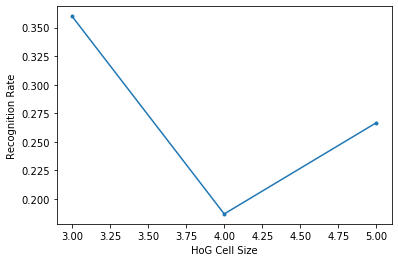

The best performing cell size is 3 with a recognition rate of 0.36.


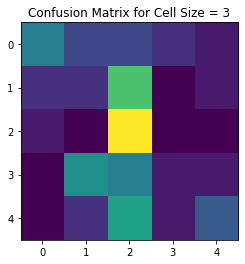

In [20]:
recognitionRates = np.zeros(3)
predictedLabels = np.empty((3, 75))

for i in range(3):
    # cluster HoG descriptors into K clusters using the Gaussian Mixture model
    emHoG = GaussianMixture(n_components=num_components)
    emHoG = emHoG.fit(np.concatenate(trnHoGFeatures[i]))
    
    trnHoGHistograms = buildHistograms(trnHoGFeatures[i], emHoG)
    tstHoGHistograms = buildHistograms(tstHoGFeatures[i], emHoG)
    
    predictedLabels[i] = findNearestNeighbour(trnHoGHistograms, tstHoGHistograms)
    recognitionRates[i] = accuracy_score(labels, predictedLabels[i])
    
#     # display images if desired 
#     plt.figure(figsize=(20,12))
#     for index, (headshot, histLabel) in enumerate(zip(testHeadshots, predictedLabels)):
#         plt.subplot(5, 15, index + 1)
#         plt.title(names[histLabel])
#         plt.xticks([]), plt.yticks([])
#         plt.imshow(headshot)
#     plt.show()
    
plt.plot([3, 4, 5], recognitionRates, marker="."), plt.xlabel("HoG Cell Size"), plt.ylabel("Recognition Rate")
plt.show()
bestPerformer = np.argmax(recognitionRates)
print('The best performing cell size is {} with a recognition rate of {}.'.format(bestPerformer + 3, recognitionRates[bestPerformer]))
plt.imshow(confusion_matrix(labels, predictedLabels[bestPerformer]))
plt.title('Confusion Matrix for Cell Size = {}'.format(bestPerformer + 3))
plt.show()

### Comparison of HoG and LBP Performance
TODO